<h1><center>🏠🏠House Rent Prediction 🏠🏠</center></h1> 

## 📋 เกี่ยวกับชุดข้อมูล
ใช้ชุดข้อมูลจากเว็บไซต์ Kaggle ซึ่งเกี่ยวกับข้อมูลที่อยู่อาศัยที่สามารถให้เช่าอยู่ได้ในประเทศอินเดีย [Linked to Kaggle website](https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset)

📑 ซึ่งในข้อมูลจะประกอบไปด้วย :
- `BHK`: จำนวนห้องนอนห้องนั่งเล่นเเละห้องครัวรวมกัน
- `Rent`: ค่าเช่าของห้อง
- `Size`: ขนาดของที่ห้อง (ตารางฟุต)
- `Floor`: ห้องที่สามารถเช่าได้อยู่ชั้นใดของที่อยู่อาศัยเเละมีทั้งหมดกี่ชั้น (เช่น :ชั้นล่างสุดจากทั้งหมด 2 ชั้น, ชั้น 3 จากทั้งหมด 5)
- `Area Type`: ขนาดพื้นที่คำนวนจาก (Carpet Area: พื้นที่สามารถปูพรมได้), (ฺBuild Area: Carpet Area + พื้นที่กำเเพง), (Super Area: Build Area + พื้นที่ส่วนอื่นๆ
- `Area Locality`: ใกล้กับสถานที่ใดบ้าง
- `City`: ที่อยู่ของที่อยู่อาศัย
- `Furnishing Status`: สถานะเฟอร์นิเจอร์ในห้องเช่า (ไม่มีเฟอร์นิเจอร์ ,มีบ้างเล็กน้อย ,มีเฟอร์นิเจอร์) 
- `Tenant Preferred`: ประเภทของผู้เช่าที่เจ้าของอนุญาตให้เช่า
- `Bathroom`: จำนวนห้องน้ำ
- `Point of Contact`: บุคคลที่สามารถติดต่อสอบถามเพิ่มเติมได้เกี่ยวกับการเช่าที่อยู่อาศัย

# 📚 Import Library


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# ✏️ Define Functions & Read Dataset

In [2]:
def shape(df,df_name):
    print(f'ขนาดข้อมูลของ : "{df_name}" = {df.shape}')

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f' จำนวนข้อมูลของ : "{column}"')
        display(vc_df)
def one_hot_encode(df, column):
    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(df[column])
    # Drop column as it is now encoded
    df = df.drop(column,axis = 1)
    print(f"one hot encoded {column}")
    # Join the encoded df
    df = df.join(one_hot)
    return df
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("เเก้ไขชื่อคอลัมป์ทั้งหมดให้เป็นตัวพิมพ์เล็กเเละเเทนที่การเว้นวรรคด้วย underscore")
    print("ลบข้อมูลที่ซ้ำกันที่เป็นส่วนเกิน")
    return df
df = pd.read_csv("House_Rent_Dataset.csv")
shape(df,'df')
df.head()

ขนาดข้อมูลของ : "df" = (4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


<br>

# 🧹 การ Clean ข้อมูล


In [3]:
# แก้ไขดัดแปลงข้อมูล.
shape(df,'df')
df2 = trim(df)
shape(df,'df')

# แก้ไขคอลัมป์ "floor"
df2 = df2.join(df2['floor'].str.split(' out of ', 1, expand=True).rename(columns={0:'floor_level', 1:'total_floor'}))
df2['floor_level'] = df2.apply(lambda x: 0 if x['floor_level'] =='Ground' \
                               else ( -1 if x['floor_level'] =='Lower Basement' else (x['total_floor']) ) , axis=1)
print("\033[1mแก้ไขค่าในคอลัมป์ floor\033[0m : 'Ground'=0, 'Lower Basement'=-1, Rest = total_floor")
df2.drop('floor',axis=1,inplace=True)

# ลบข้อมูลที่มีค่าเป็น NULL(N/A)
df2 = df2.dropna()
shape(df,'df')

# แก้ไข data type
df2['floor_level'] = df2['floor_level'].astype('int64')
df2['total_floor'] = df2['total_floor'].astype('int64')

df2['posted_on'] = pd.to_datetime(df2["posted_on"],errors='coerce')
display(df2.head())


ขนาดข้อมูลของ : "df" = (4746, 12)
เเก้ไขชื่อคอลัมป์ทั้งหมดให้เป็นตัวพิมพ์เล็กเเละเเทนที่การเว้นวรรคด้วย underscore
ลบข้อมูลที่ซ้ำกันที่เป็นส่วนเกิน
ขนาดข้อมูลของ : "df" = (4746, 12)
แก้ไขค่าในคอลัมป์ floor : 'Ground'=0, 'Lower Basement'=-1, Rest = total_floor
ขนาดข้อมูลของ : "df" = (4746, 12)


C:\Users\picth\AppData\Local\Temp\ipykernel_12480\3368249499.py:7: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df2 = df2.join(df2['floor'].str.split(' out of ', 1, expand=True).rename(columns={0:'floor_level', 1:'total_floor'}))


,posted_on,bhk,rent,size,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,floor_level,total_floor
0,2022-05-18,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2
1,2022-05-13,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
2,2022-05-16,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
3,2022-07-04,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,2
4,2022-05-09,2,7500,850,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,2


In [4]:
df2.info()

# ตรวจสอบจำนวนของข้อมูลทั้งหมด
for col in df2.select_dtypes(include=['object']).columns:
    vc(df2, col)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4742 entries, 0 to 4745
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   posted_on          4742 non-null   datetime64[ns]
 1   bhk                4742 non-null   int64         
 2   rent               4742 non-null   int64         
 3   size               4742 non-null   int64         
 4   area_type          4742 non-null   object        
 5   area_locality      4742 non-null   object        
 6   city               4742 non-null   object        
 7   furnishing_status  4742 non-null   object        
 8   tenant_preferred   4742 non-null   object        
 9   bathroom           4742 non-null   int64         
 10  point_of_contact   4742 non-null   object        
 11  floor_level        4742 non-null   int64         
 12  total_floor        4742 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 518.7+ 

,count,percentage (%)
area_type,,
Super Area,2444,51.539435
Carpet Area,2296,48.418389
Built Area,2,0.042176


 จำนวนข้อมูลของ : "area_locality"


,count,percentage (%)
area_locality,,
Bandra West,37,0.780261
Gachibowli,29,0.611556
Electronic City,24,0.506116
Velachery,22,0.463939
"Miyapur, NH 9",22,0.463939
...,...,...
Mandirtala,1,0.021088
"Mandakini Enclave, Alaknanda",1,0.021088
"DDA Akshardham Apartments, DS 19",1,0.021088


 จำนวนข้อมูลของ : "city"


,count,percentage (%)
city,,
Mumbai,972,20.497680
Chennai,891,18.789540
Bangalore,886,18.684100
Hyderabad,866,18.262337
Delhi,603,12.716154
Kolkata,524,11.050190


 จำนวนข้อมูลของ : "furnishing_status"


,count,percentage (%)
furnishing_status,,
Semi-Furnished,2250,47.448334
Unfurnished,1814,38.253901
Furnished,678,14.297765


 จำนวนข้อมูลของ : "tenant_preferred"


,count,percentage (%)
tenant_preferred,,
Bachelors/Family,3441,72.564319
Bachelors,830,17.503163
Family,471,9.932518


 จำนวนข้อมูลของ : "point_of_contact"


,count,percentage (%)
point_of_contact,,
Contact Owner,3212,67.735133
Contact Agent,1529,32.243779
Contact Builder,1,0.021088


In [5]:
# ตัดข้อมูลที่โดดออกมา (ข้อมูลที่มีค่าน้อยกว่าหรือมากกว่าข้อมูลทั่วไปมากๆ)
shape(df2,'df2')
df3 = df2[~df2['point_of_contact'].str.contains("Contact Builder")]
df3 = df3[~df3['area_type'].str.contains("Built Area")]
shape(df3,'df3')

area_locality_temp = vc(df3, 'area_locality',True)
area_locality_temp = area_locality_temp[area_locality_temp['count']==1]
print(f"Number of unique area_locality is {area_locality_temp.shape[0]} ")

# replace unique value to others
df3['area_locality'] = df3['area_locality'].replace(area_locality_temp.index, 'Others')
area_locality_temp = vc(df3, 'area_locality',True)

# extract date time
#df3['month_posted'] = df3['posted_on'].dt.month
#df3['day_posted'] = df3['posted_on'].dt.day
#df3['day_of_week_posted'] = df3['posted_on'].dt.day_of_week
#df3['day_of_week_posted'] = df3['posted_on'].dt.day_of_week
#df3['quarter_poster'] = df3['posted_on'].dt.quarter


# drop datetime
df3.drop('posted_on',axis=1,inplace=True)
df3.head()

ขนาดข้อมูลของ : "df2" = (4742, 13)
ขนาดข้อมูลของ : "df3" = (4739, 13)
Number of unique area_locality is 1461 


,bhk,rent,size,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,floor_level,total_floor
0,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2
1,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
2,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
3,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,2
4,2,7500,850,Carpet Area,Others,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,2


## ⌨️ One Hot Coding 
>One Hot Encoding คือ การ Encode ข้อมูล Categorical Data ที่ปกติเก็บเป็น Nomimal Number, Ordinal Number ให้แตกเป็น Column ย่อย ๆ แบบ Binary 0/1 ตาม Value ของข้อมูล 

In [32]:
df4 = df3.copy()
columns = ['area_type', 'city','furnishing_status','tenant_preferred','point_of_contact']
for col in columns:
    df4 = one_hot_encode(df4, col)
df4

one hot encoded area_type
one hot encoded city
one hot encoded furnishing_status
one hot encoded tenant_preferred
one hot encoded point_of_contact


,bhk,rent,size,area_locality,bathroom,floor_level,total_floor,Carpet Area,Super Area,Bangalore,...,Kolkata,Mumbai,Furnished,Semi-Furnished,Unfurnished,Bachelors,Bachelors/Family,Family,Contact Agent,Contact Owner
0,2,9.210440,1100,Bandel,2,0,2,0,1,0,...,1,0,0,0,1,0,1,0,0,1
1,2,9.903538,800,"Phool Bagan, Kankurgachi",1,3,3,0,1,0,...,1,0,0,1,0,0,1,0,0,1
2,2,9.741027,1000,Salt Lake City Sector 2,1,3,3,0,1,0,...,1,0,0,1,0,0,1,0,0,1
3,2,9.210440,800,Dumdum Park,1,2,2,0,1,0,...,1,0,0,0,1,0,1,0,0,1
4,2,8.922792,850,Others,1,2,2,1,0,0,...,1,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2,9.615872,1000,Bandam Kommu,2,5,5,1,0,0,...,0,0,0,1,0,0,1,0,0,1
4742,3,10.275086,2000,Others,3,4,4,0,1,0,...,0,0,0,1,0,0,1,0,0,1
4743,3,10.463132,1750,"Himayath Nagar, NH 7",3,5,5,1,0,0,...,0,0,0,1,0,0,1,0,1,0
4744,3,10.714440,1500,Gachibowli,2,34,34,1,0,0,...,0,0,0,1,0,0,0,1,1,0


<br>

# ⚙️การประมวลผลข้อมูล

 $\;\;\;\;\;$**4 ข้อที่ควรตวจสอบก่อนวิเคราะห์ Regression**
> 1. `Linearity` : ความสัมพันธ์ระหว่างตัวแปรอิสระ (X) กับตัวแปรตาม (Y) เป็นเส้นตรง
> 2. `Homoscedasticity` : ความแปรปรวนของความคลาดเคลื่อน (Residual) เท่ากันสำหรับทุกค่า X
> 3. `Independence` : ตัวแปรอิสระไม่เกี่ยวข้องกันมากเกินไป
> 4. `Normality` : การแจกแจงของตัวแปรตามเป็นแบบโค้งปกติ (Normal Distribution) ที่ทุกค่าของ X

จาก
> 1. `Linearity` : ความสัมพันธ์ระหว่างตัวแปรอิสระ (X) กับตัวแปรตาม (Y) เป็นเส้นตรง

เริ่มจาก Plot กราฟเพื่อตรวจสอบความสัมพันธ์ของเเต่ละตัวแปร

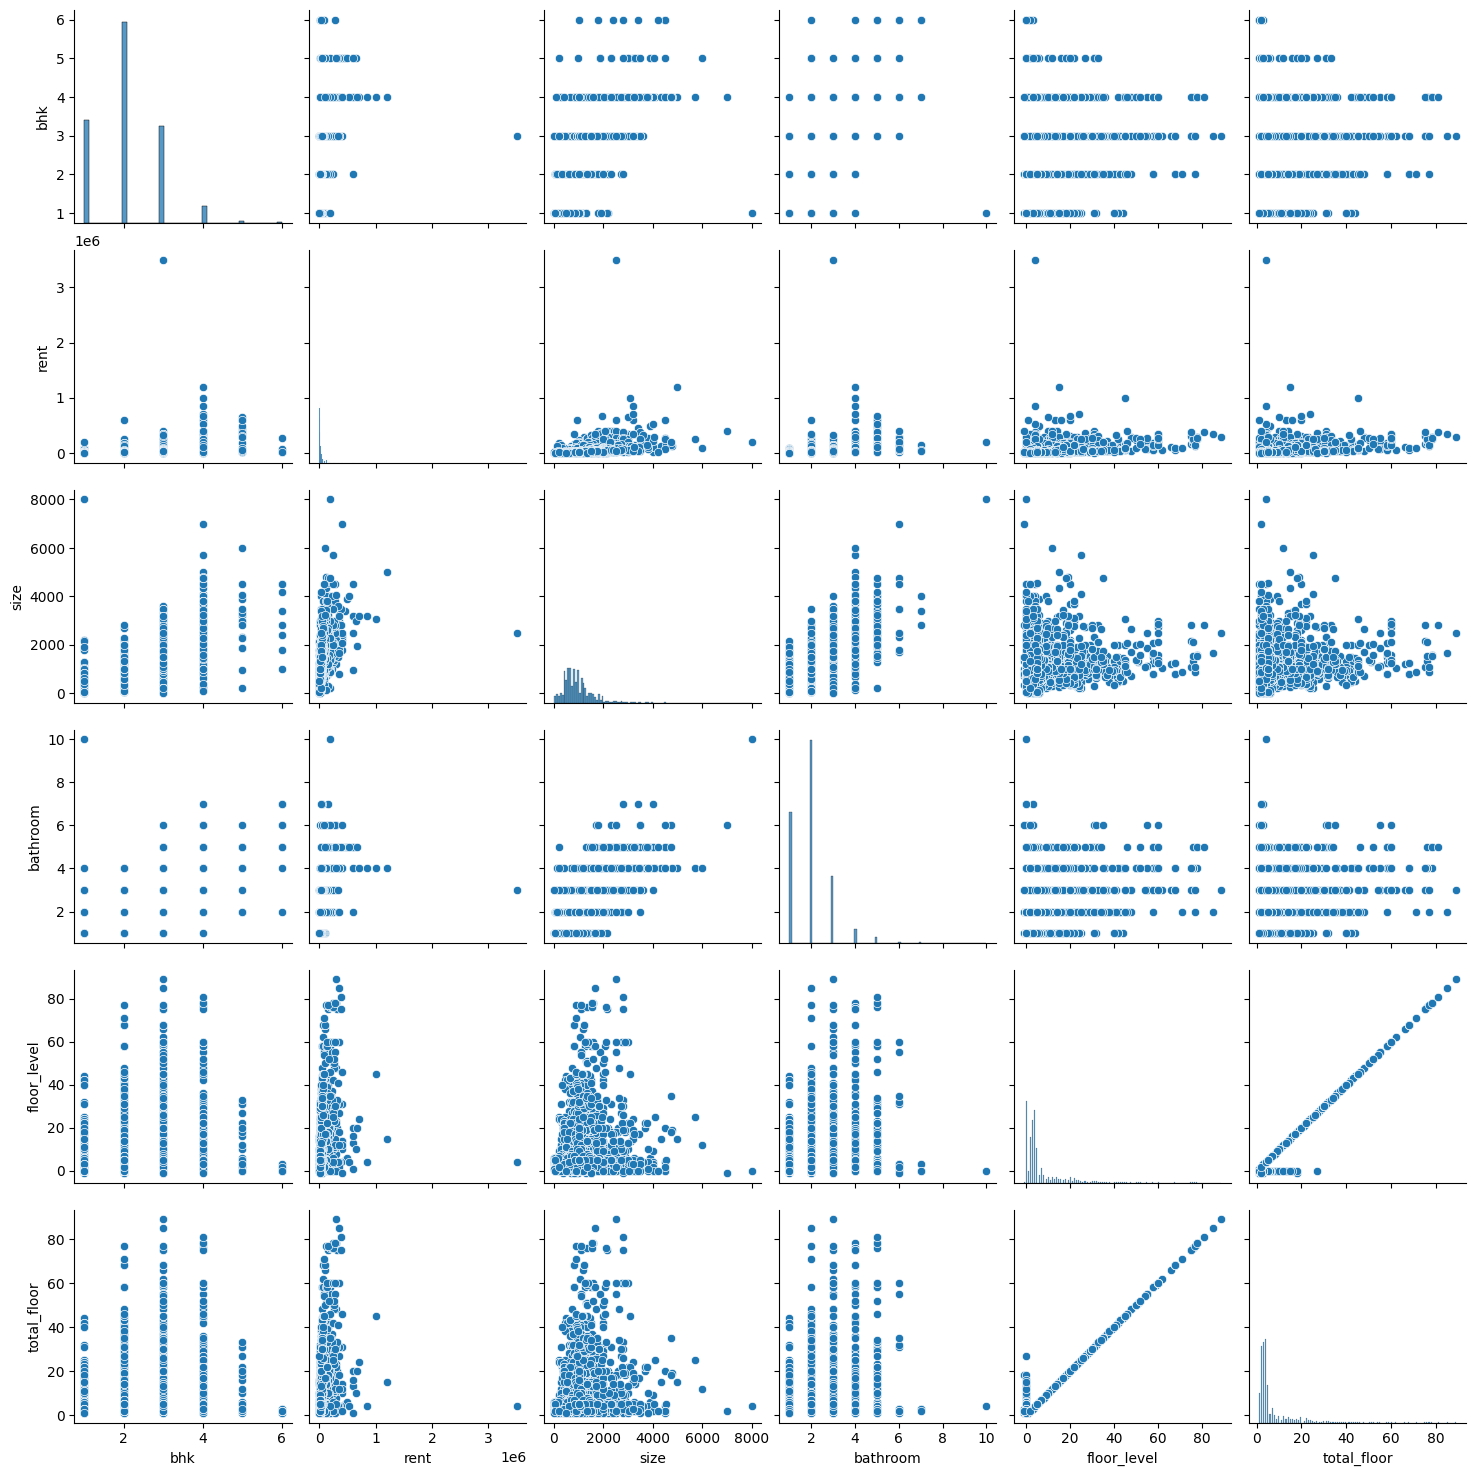

In [8]:
sns.pairplot(df3)

จาก
> 3\. `Independence` : ตัวแปรอิสระไม่เกี่ยวข้องกันมากเกินไป

ตรวจสอบความสัมพันธ์ของตัวแปรอิสระโดยใช้ Pearson's correlation  
<div>
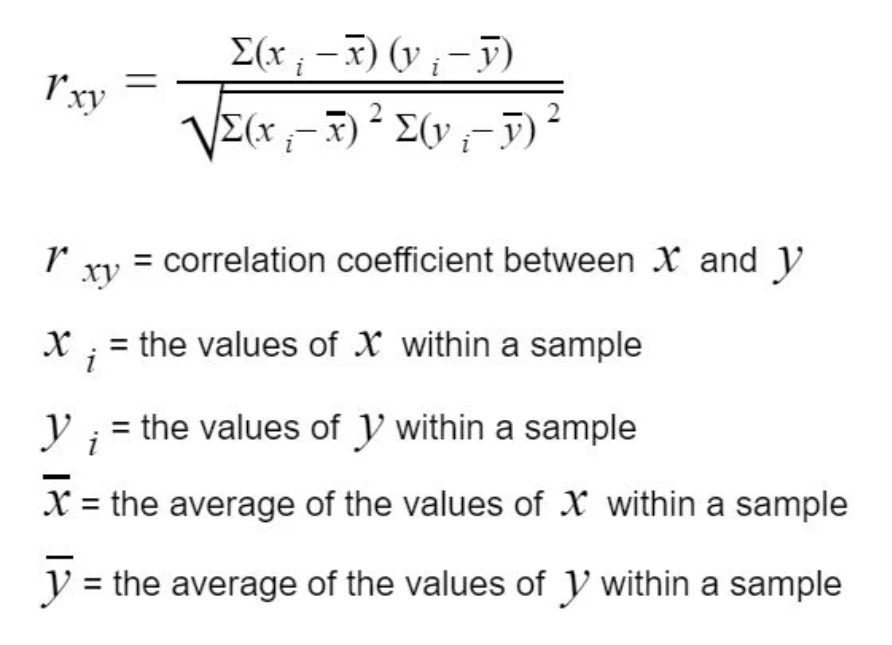
</div>

In [33]:
df5 = df4.drop('area_locality', axis=1)
df5.corr()

,bhk,rent,size,bathroom,floor_level,total_floor,Carpet Area,Super Area,Bangalore,Chennai,...,Kolkata,Mumbai,Furnished,Semi-Furnished,Unfurnished,Bachelors,Bachelors/Family,Family,Contact Agent,Contact Owner
bhk,1.000000,0.596434,0.716168,0.794829,0.246580,0.248057,0.154604,-0.154604,-0.088846,0.023418,...,-0.050231,0.023339,0.042032,0.132826,-0.166754,0.033438,-0.104816,0.113870,0.231227,-0.231227
rent,0.596434,1.000000,0.567909,0.692269,0.559384,0.555309,0.383179,-0.383179,-0.124962,-0.119765,...,-0.273982,0.573771,0.207663,0.102071,-0.254417,0.083744,-0.168624,0.145140,0.617039,-0.617039
size,0.716168,0.567909,1.000000,0.740673,0.185644,0.189417,0.080051,-0.080051,0.013639,0.048411,...,-0.100327,-0.049626,0.051564,0.164168,-0.205825,0.034304,-0.094934,0.098029,0.214241,-0.214241
bathroom,0.794829,0.692269,0.740673,1.000000,0.362020,0.361965,0.184277,-0.184277,-0.093787,0.017629,...,-0.213322,0.184110,0.075480,0.142600,-0.200883,0.031287,-0.119556,0.138588,0.327774,-0.327774
floor_level,0.246580,0.559384,0.185644,0.362020,1.000000,0.990092,0.290810,-0.290810,-0.117388,-0.146012,...,-0.184989,0.584276,0.062075,0.060419,-0.106783,0.012297,-0.111113,0.150119,0.469170,-0.469170
total_floor,0.248057,0.555309,0.189417,0.361965,0.990092,1.000000,0.286488,-0.286488,-0.115587,-0.147955,...,-0.169897,0.581102,0.059804,0.059301,-0.103999,0.009142,-0.108349,0.150005,0.465091,-0.465091
Carpet Area,0.154604,0.383179,0.080051,0.184277,0.290810,0.286488,1.000000,-1.000000,-0.100998,-0.125621,...,0.013635,0.367120,0.051885,0.002449,-0.039878,0.320903,-0.364899,0.136620,0.561982,-0.561982
Super Area,-0.154604,-0.383179,-0.080051,-0.184277,-0.290810,-0.286488,-1.000000,1.000000,0.100998,0.125621,...,-0.013635,-0.367120,-0.051885,-0.002449,0.039878,-0.320903,0.364899,-0.136620,-0.561982,0.561982
Bangalore,-0.088846,-0.124962,0.013639,-0.093787,-0.117388,-0.115587,-0.100998,0.100998,1.000000,-0.230589,...,-0.169077,-0.243586,-0.055018,0.177037,-0.142301,-0.028730,0.062135,-0.056185,-0.120245,0.120245
Chennai,0.023418,-0.119765,0.048411,0.017629,-0.146012,-0.147955,-0.125621,0.125621,-0.230589,1.000000,...,-0.169546,-0.244262,-0.072790,0.027528,0.024126,-0.026833,0.002823,0.029878,-0.177004,0.177004


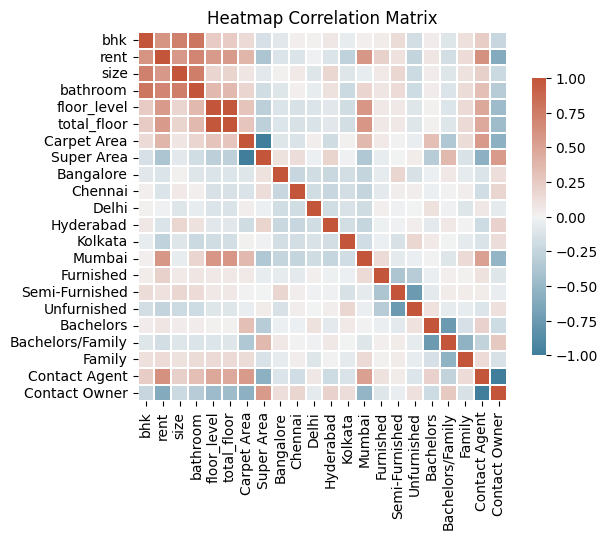

In [34]:
# Define a nice color map for our heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
        data=df5.corr(),  # our correlation matrix
        linewidths=0.3,  # the width of lines separating the matrix squares
        square=True,   # enforce 1:1 ratios among correlation cells
        cmap=cmap,  # use the color map we defined above
        vmax=1,  # define the max of our correlation scale
        vmin=-1, # define the min of our correlation scale
        center=0,  # The value at which the color map is centered about (white)
        cbar_kws={"shrink": .75}  # shrink the scale a bit
    )
# adjust y-axis ticks for legibility
plt.yticks(rotation=0)  
plt.title(f'Heatmap Correlation Matrix')
# show the heatmap
plt.show()

จาก
> 4\. `Normality` : การแจกแจงของตัวแปรตามเป็นแบบโค้งปกติ (Normal Distribution) ที่ทุกค่าของ X

ตรวจสอบการแจกแจงของราคาเช่าบ้าน

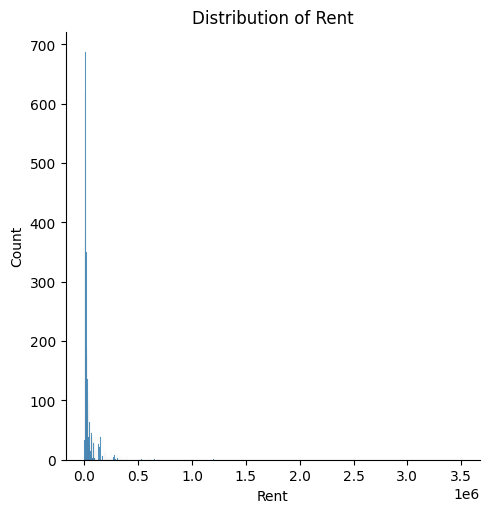

กราฟมีการกระจายตัวแบบโค้งเบ้ลาดขวา


In [31]:
def vis_dist(df, col, lim=False):
    variable = df[col].values
    ax = sns.displot(variable)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    if lim:
        plt.xlim(0, 4000)
    return plt.show()
vis_dist(df, 'Rent')
print("กราฟมีการกระจายตัวแบบโค้งเบ้ลาดขวา")


เพื่อให้สะดวกต่อการดูการกระจายของข้อมูลที่ชัดขึ้น จึงลดสเกลของกราฟลง

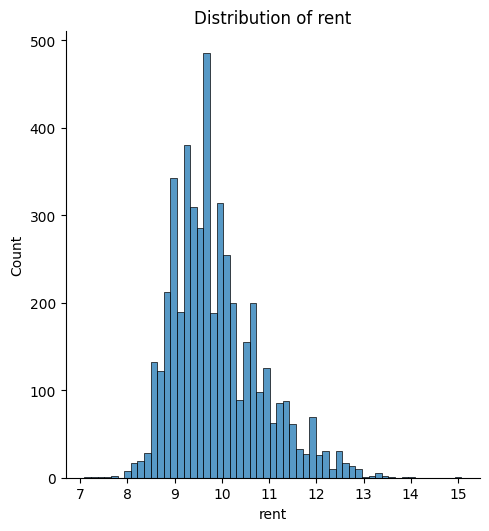

In [11]:
df3['rent'] = np.log1p(df3['rent'])
vis_dist(df3, 'rent')

# 🎓 Training a Linear Regression Model

สมการที่ใช้การทำนายของ Linear Regression คือ  
$$\hat{y} = θ_0x_0 + θ_1x_1 + θ_2x_2 + \ldots + θ_nx_n$$  
โดยที่  
$\hat{y}$: ค่าที่โมเดลทำนายออกมา  
$\theta$: model parameters  
$x$: feature value  
$n$: จำนวน feature ในชุดข้อมูล  
$x_0$: 1 (สำหรับการคูณ vector)  
$\theta_0$: Intercept

สังเกตว่าสมการนี้คือ dot product ระหว่าง θ กับ x จึงสามารถเขียนสมการใหม่ได้ออกมาเป็น
$$\hat{y} = \boldsymbol{x}^T \boldsymbol{\theta}$$

แต่ในการคำนวณจริง เราจำเป็นต้องคำนวณค่า $\hat{y}$ หลายตัวพร้อมกัน  
จึงให้ X เป็น matrix ที่มี $n$ แถวแทนจำนวนชุดข้อมูล และ $i$ คอลัมน์แทนจำนวน feature
$$
\begin{bmatrix}  
x_0^0  & \cdots & x_i^0  \\
\vdots & \ddots & \vdots \\
x_0^n  & \cdots & x_i^n  \\
\end{bmatrix}  
\begin{bmatrix}  
\theta_0 \\
\vdots   \\
\theta_i \\
\end{bmatrix} = 
\begin{bmatrix}  
\hat{y}_0 \\
\vdots  \\
\hat{y}_n \\
\end{bmatrix}  
$$
$$\boldsymbol{\hat{y}} = X\boldsymbol{\theta}$$

# 📌 กำหนดตัวแปรอิสระ X และตัวแปรตาม y

In [37]:
RANDOM_NUMBER = 42
y =df5[['rent']].values
X = df5.drop('rent',axis=1)

### Splitting in to Train and Test Dataset

$\;\;\;\;$**แบ่งข้อมูลออกเป็น 2 ชุด**
>1. สำหรับการฝึกโมเดล
>2. สำหรับการทดสอบ

In [38]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn import tree

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_NUMBER)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    shape(X_train,'X_train') ; shape(X_test,'X_test') ; shape(y_train,'y_train') ; shape(y_test,'y_test')
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(X, y)

ขนาดข้อมูลของ : "X_train" = (3791, 21)
ขนาดข้อมูลของ : "X_test" = (948, 21)
ขนาดข้อมูลของ : "y_train" = (3791,)
ขนาดข้อมูลของ : "y_test" = (948,)


### ระบุตัวกำหนดในการทำนาย

In [40]:
# select attributes using Random Forest Regressor
def select_feature_dtc(X_train,y_train, selected_estimator):
    # get selector.threshold_
    selector = SelectFromModel(estimator=selected_estimator).fit(X_train, y_train)
    print(f'selector.threshold_ = {selector.threshold_}')

    feature_name = X_train.columns[selector.get_support()]
    print(f'Number of selected features = {feature_name.shape[0]}')

    # put it into a data frame
    d = {'columns': X_train.columns.tolist(),  'support':selector.get_support()}
    df = pd.DataFrame(data=d)
    df = df[df.support ==True]
    df.reset_index(inplace = True, drop=True)
    return df, feature_name

selected_estimator = RandomForestRegressor(random_state=RANDOM_NUMBER)
df, feature_name = select_feature_dtc(X_train, y_train, selected_estimator)
df

selector.threshold_ = 0.047619047619047616
Number of selected features = 5


,columns,support
0,size,True
1,bathroom,True
2,Mumbai,True
3,Contact Agent,True
4,Contact Owner,True


# Closed Form Equation

เป็นการคำนวณหาค่า model parameters โดยตรง

โดยเราจะกำหนด cost function แล้วหา model parameter ที่ทำให้ cost function มีค่าน้อยที่สุดที่เป็นไปได้  
cost function ที่จะใช้คือ Mean Squared Error (MSE)
$$MSE(\hat{y}, y) = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i-y_i)^2$$
โดยที่  
$\hat{y}$: ข้อมูลที่โมเดลทำนายออกมา  
$y$: ข้อมูลที่แท้จริง  
$n$: จำนวนข้อมูล  
<br>
ซึ่งสามารถจัดรูปใหม่ได้เป็น
$$MSE(\boldsymbol{\hat{y}}, \boldsymbol{y}) = \frac{1}{n} (\boldsymbol{\hat{y}} - \boldsymbol{y})^T(\boldsymbol{\hat{y}} - \boldsymbol{y})$$

แล้วนำ $\boldsymbol{\hat{y}} = X\boldsymbol{\theta}$ มาแทนในสมการ จะได้
$$MSE(X, \boldsymbol{\theta}, \boldsymbol{y}) = \frac{1}{n} (X\boldsymbol{\theta} - \boldsymbol{y})^T(X\boldsymbol{\theta} - \boldsymbol{y})$$


$$\begin{matrix} \text{Vector derivative} \\ \text{(B is a constant matrix)} \end{matrix}$$
$$
\begin{array}{c c c}
\hline
\\ f(x) & \rightarrow & \frac{df}{dx} \\ \\
\hline \\
\boldsymbol{x}^TB & \rightarrow & B \\ 
\boldsymbol{x}^T\boldsymbol{b} & \rightarrow & \boldsymbol{b} \\ 
\boldsymbol{x}^T\boldsymbol{x} & \rightarrow & 2\boldsymbol{x} \\
\boldsymbol{x}^TB\boldsymbol{x} & \rightarrow & 2B\boldsymbol{x} \\
\end{array}
$$
ตารางสรุป [vector derivative](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) สำหรับการหา derivative ของ MSE
<br>
เราต้องการหา $\boldsymbol{\theta}$ ที่ทำให้ MSE มีค่าออกมาน้อยที่สุดเท่าที่เป็นไปได้ จึงต้องทำการหา partial derivative ของ MSE เทียบกับ $\boldsymbol{\theta}$

<div>
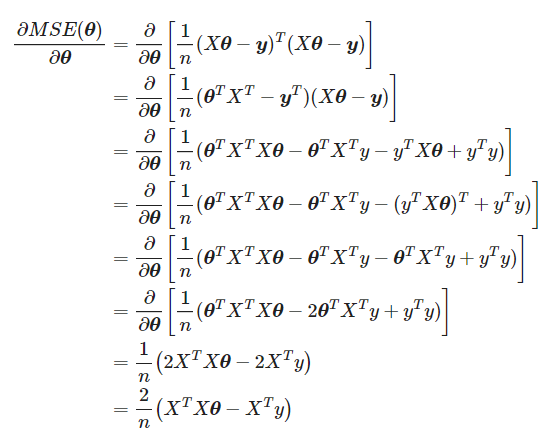
</div>

จากนั้นหาค่าวิกฤตของ $\theta$ ที่ทำให้ $\parMSE$ เท่ากับ 0
<div>
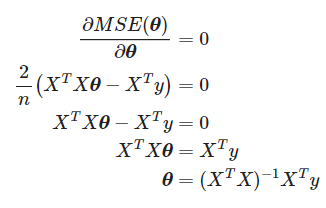
</div>

# สร้างฟังก์ชันในการทำนาย

In [41]:
def test_predict(model,X_train,X_test,y_train,y_test, parameters = None):
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    model_text_list=[]; metric_list=[]; score_list=[] ; param_list=[]
    
    # create list of metric to be examined
    metric_functions = [r2_score, r2_score, mean_squared_error,mean_squared_error,mean_absolute_error]
    metric_functions_text = ['R_Squared', 'Adj_R_Squared', 'MSE','RMSE','MAE']
    
    # for loop of each of the 5 metrics
    for metric_function, metric_function_text in zip(metric_functions, metric_functions_text):
        if metric_function_text == 'Adj_R_Squared':
            Adj_r2 = 1 - (1-r2_score(y_test, prediction_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
            model_text_list.append(type(model).__name__); metric_list.append(metric_function_text); score_list.append(Adj_r2); param_list.append(parameters)
        elif metric_function_text == 'RMSE':
            rmse = mean_squared_error(y_test, prediction_test, squared=False)
            model_text_list.append(type(model).__name__); metric_list.append(metric_function_text); score_list.append(rmse); param_list.append(parameters)
        else:
            model_text_list.append(type(model).__name__); metric_list.append(metric_function_text); score_list.append(metric_function(y_test, prediction_test)); param_list.append(parameters) 
    
    d = {'model':model_text_list, 'parameters': param_list ,'metric': metric_list, 'test predict score': score_list}
    df = pd.DataFrame(data=d)
    return df

def five_cv_prarm_grid(PARAM_DICT, ESTIMATOR,X_train,y_train):
    sh = HalvingGridSearchCV(ESTIMATOR, PARAM_DICT, cv=10, scoring='neg_mean_absolute_error',min_resources="smallest",random_state=RANDOM_NUMBER).fit(X_train, y_train)
    best_estimator = sh.best_estimator_
    best_param = sh.best_params_
    print(best_estimator)
    print(f"10-CV Best Parameters = {best_param}")
    print(f"10-CV Best Score = {sh.best_score_}")
    return best_estimator, best_param

def cross_validation(model, treated_X, y):
    # drop na columns
    treated_X = treated_X.dropna(axis=1)
    # train test split
    X_train, X_test, y_train, y_test = split_data(treated_X, y)
    # cross validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    mean = scores.mean() ; std =scores.std()
    print(f"Average neg_mean_absolute_error: {mean}   , Std: {std}")
    print()
    return mean

# Cross Validation เพื่อ Standardisation
K-Fold Cross Validation คือการที่เราแบ่งข้อมูลเป็นจำนวน K ส่วนโดยการในแต่ละส่วนจะต้องมาจากสุ่มเพื่อที่จะให้ข้อมูลของเรากระจายเท่าๆกัน เเล้วนำ Training Data ของเราไปหา Regression Line และทดสอบครับว่าข้อมูลชุดไหนที่ทำให้เส้นของเราทำนายได้ดีที่สุด

In [39]:
model = RandomForestRegressor(random_state=RANDOM_NUMBER)

print("10 fold cross validation, where the higher the value, the better, this is because the MAE is negated")
print()

# normalisation (min max scalling)
print("normalisation (min max scalling)")
normalized_X = (X-X.min())/(X.max()-X.min())
norm_score = cross_validation(model, normalized_X, y)

# standardisation
print("standardisation")
standardized_X = (X-X.mean())/X.std()
std_score = cross_validation(model, standardized_X, y)

if norm_score> std_score:
    print(f"Normalisation is better than standardisation, where {norm_score}>{std_score}")
    print("Normalisation is chosen")
    X_train, X_test, y_train, y_test = split_data(normalized_X, y)
else:
    print(f"Standardisation is better than normalisation, where {std_score}>{norm_score}")
    print("Standardisation is chosen")
    X_train, X_test, y_train, y_test = split_data(standardized_X, y)

10 fold cross validation, where the higher the value, the better, this is because the MAE is negated

normalisation (min max scalling)
ขนาดข้อมูลของ : "X_train" = (3791, 21)
ขนาดข้อมูลของ : "X_test" = (948, 21)
ขนาดข้อมูลของ : "y_train" = (3791,)
ขนาดข้อมูลของ : "y_test" = (948,)
Average neg_mean_absolute_error: -0.3001269333216066   , Std: 0.009116118915577

standardisation
ขนาดข้อมูลของ : "X_train" = (3791, 21)
ขนาดข้อมูลของ : "X_test" = (948, 21)
ขนาดข้อมูลของ : "y_train" = (3791,)
ขนาดข้อมูลของ : "y_test" = (948,)
Average neg_mean_absolute_error: -0.30018982716839304   , Std: 0.009189804265227941

Normalisation is better than standardisation, where -0.3001269333216066>-0.30018982716839304
Normalisation is chosen
ขนาดข้อมูลของ : "X_train" = (3791, 21)
ขนาดข้อมูลของ : "X_test" = (948, 21)
ขนาดข้อมูลของ : "y_train" = (3791,)
ขนาดข้อมูลของ : "y_test" = (948,)


# ประเมินผลการทำนาย

In [42]:
model = LinearRegression()
LinearRegression_test = test_predict(model, X_train,X_test,y_train,y_test)
LinearRegression_test

,model,parameters,metric,test predict score
0,LinearRegression,None,R_Squared,0.799260
1,LinearRegression,None,Adj_R_Squared,0.798367
2,LinearRegression,None,MSE,0.182545
3,LinearRegression,None,RMSE,0.427253
4,LinearRegression,None,MAE,0.305956
